                                       title                   genres
33                               Babe (1995)  Children's|Comedy|Drama
344             Bullets Over Broadway (1994)                   Comedy
847                    Godfather, The (1972)       Action|Crime|Drama
1120  Monty Python and the Holy Grail (1974)                   Comedy
1180          Raiders of the Lost Ark (1981)         Action|Adventure
1256                   Cool Hand Luke (1967)             Comedy|Drama
1258               Young Frankenstein (1974)            Comedy|Horror
1865       You Can't Take It With You (1938)                   Comedy
2220                      Player, The (1992)             Comedy|Drama
2904          Crimes and Misdemeanors (1989)                   Comedy


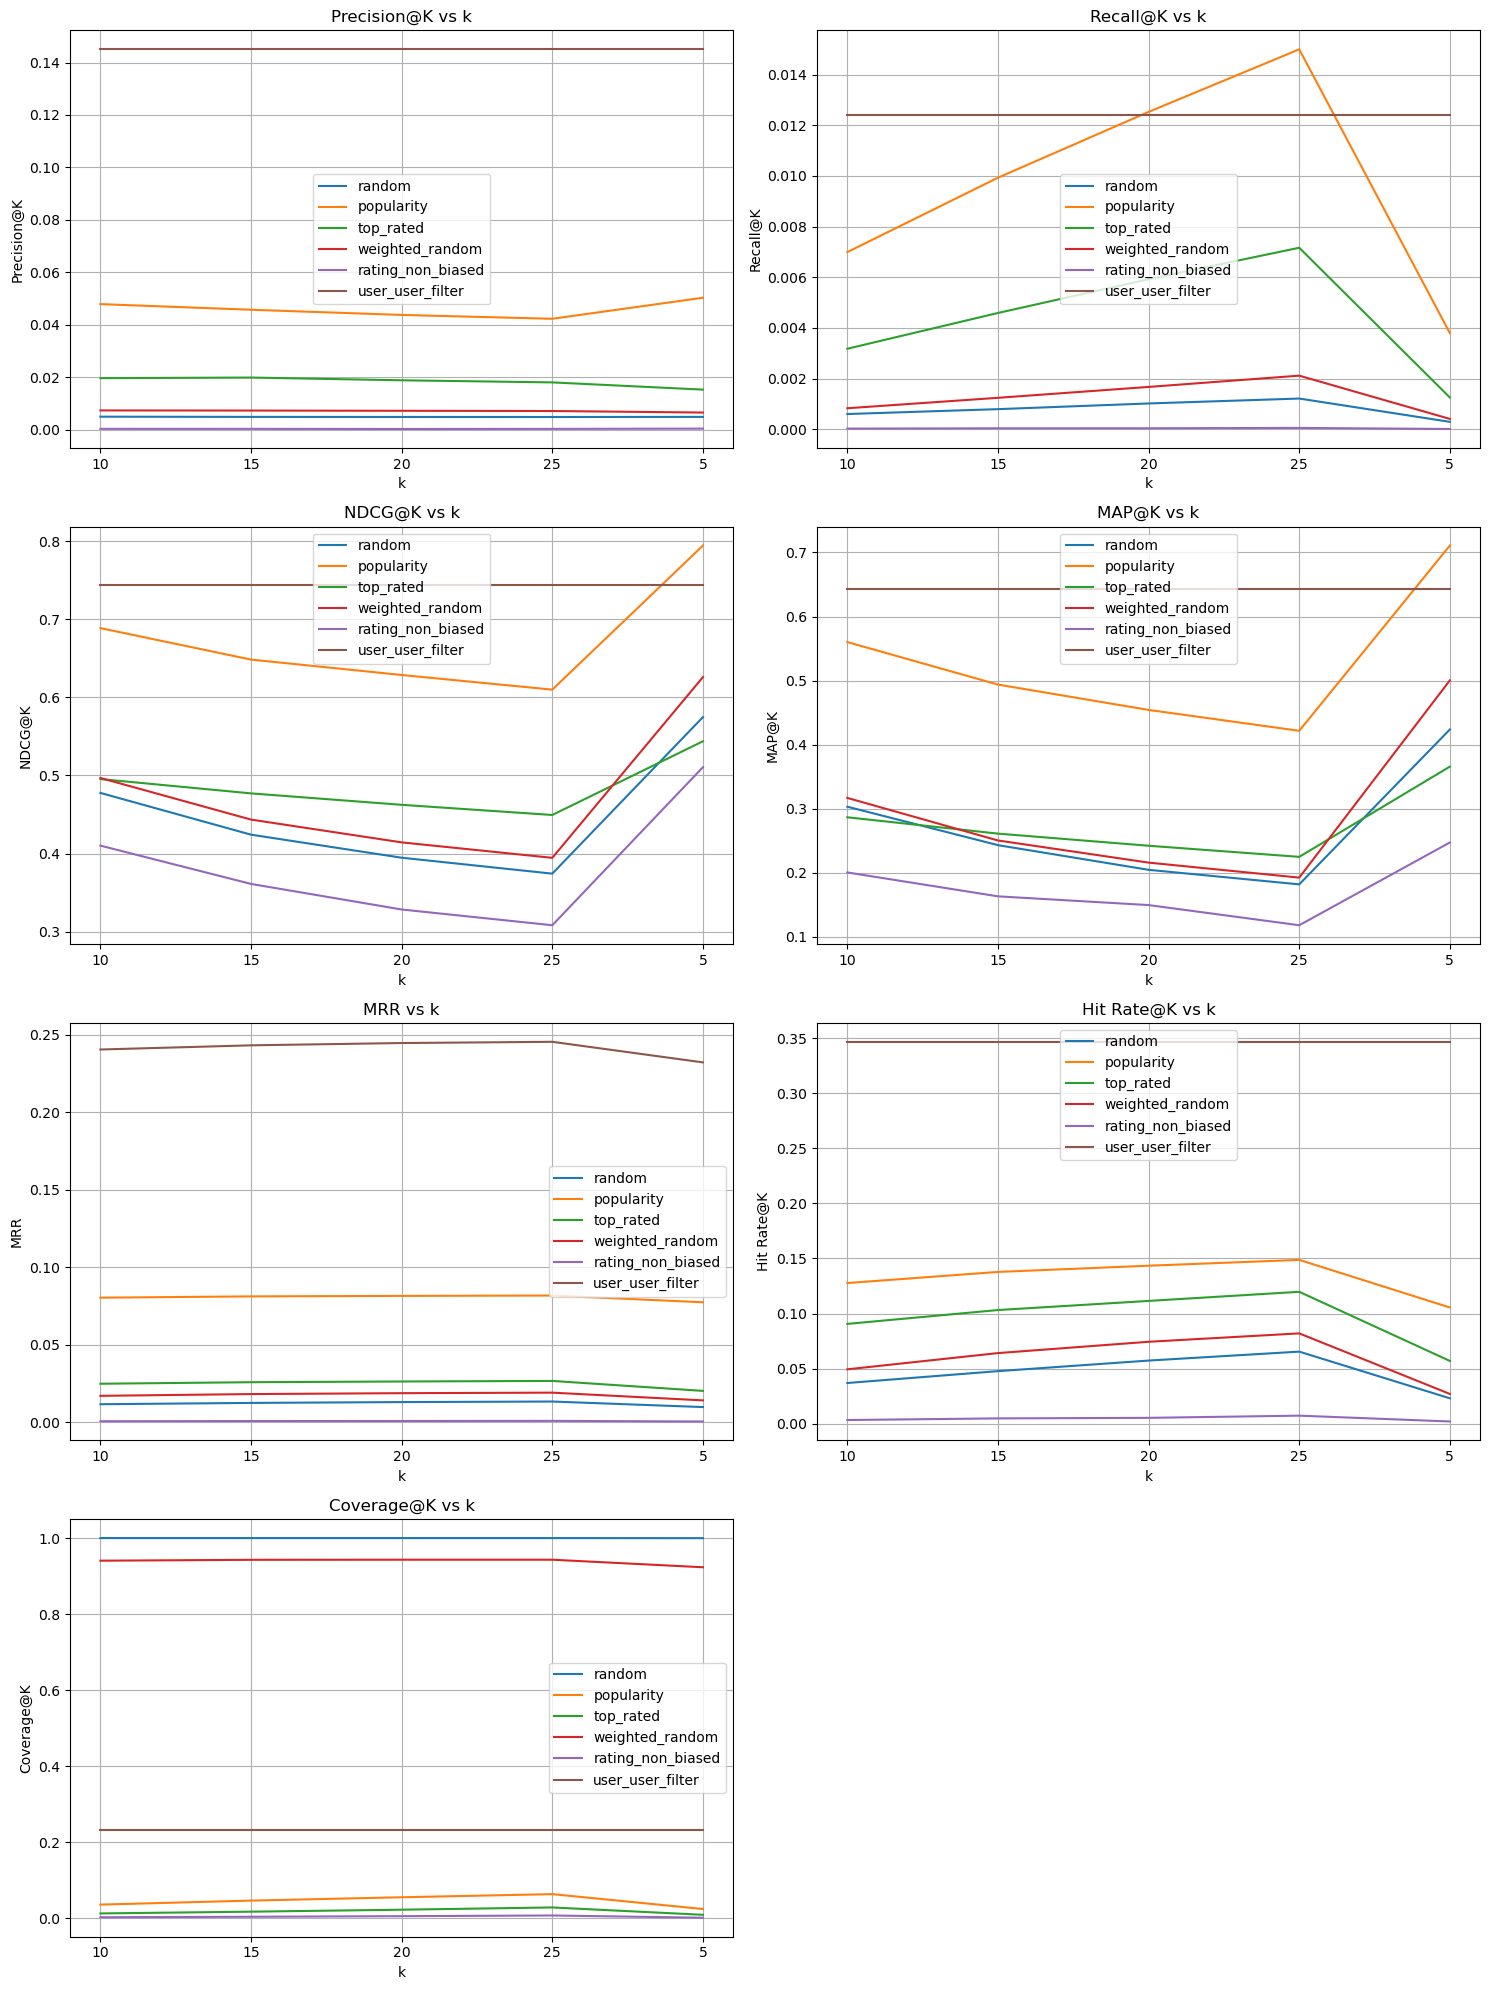

In [6]:
import sys

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# add root folder to path
folder = "../../"
sys.path.append(folder)
from src.utils import load_data
from src.utils import plot_metrics_grid
from src.utils import load_baseline_rec_result
from src.metrics import evaluate_recommender_system

users, ratings, movies = load_data('../../data/ml-1m/')

# Split data into train and test by timestamp
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
split_point = int(len(ratings) * 0.8)
sorted_ratings = ratings.sort_values(by='timestamp')
train_ratings = sorted_ratings[:split_point]
test_ratings = sorted_ratings[split_point:]

user_item_matrix = train_ratings.pivot(index='user_id', columns='movie_id', values='rating')
user_item_matrix = user_item_matrix.fillna(0)

user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)


def get_user_recommendations(user_id, user_item_matrix, user_similarity_df, n_recommendations=10):
    if user_id not in user_similarity_df.index:
        return []

    sim_scores = user_similarity_df[user_id]
    sim_users = sim_scores.sort_values(ascending=False).index[1:]
    user_ratings = user_item_matrix.loc[user_id]
    weighted_ratings = pd.Series(0, index=user_item_matrix.columns)

    sim_sum = 0
    for sim_user in sim_users:
        sim_score = sim_scores[sim_user]
        sim_ratings = user_item_matrix.loc[sim_user]
        weighted_ratings += sim_ratings * sim_score
        sim_sum += sim_score
        if sim_sum > 1:
            break

    weighted_ratings = weighted_ratings / sim_sum
    weighted_ratings = weighted_ratings[user_ratings == 0]
    recommendations = weighted_ratings.sort_values(ascending=False).head(n_recommendations)
    recommended_movie_ids = recommendations.index

    return recommended_movie_ids


user_id = test_ratings['user_id'].iloc[0]
recommended_movies = get_user_recommendations(user_id, user_item_matrix, user_similarity_df)
print(movies[movies['movie_id'].isin(recommended_movies)][['title', 'genres']])

metrics_results = {}
base_line_metrics = load_baseline_rec_result()
for i in range(5, 26, 5):
    recommendations = {}
    for user_id in test_ratings['user_id'].unique():
        recommendations[user_id] = get_user_recommendations(user_id, user_item_matrix, user_similarity_df, i)
    metrics_results[str(i)] = evaluate_recommender_system(recommendations, test_ratings, len(movies))

combined = base_line_metrics | {'user_user_filter': metrics_results}
metrics = ['Precision@K', 'Recall@K', 'NDCG@K', 'MAP@K', 'MRR', 'Hit Rate@K', 'Coverage@K']
plot_metrics_grid(combined, metrics)
